In [1]:
import matplotlib.pyplot as plt
import numpy as np

dataset = np.load('dataset.npy')

print(dataset.shape)

(300, 2)


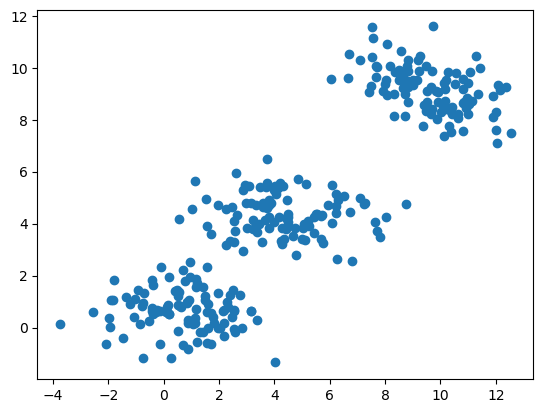

In [2]:
import pandas as pd
import math

df = pd.DataFrame(dataset)
plt.scatter(df[0],df[1])

In [3]:
def Gaussian(mean, covariance, array):
    return (1/(((2*np.pi)**2)*np.linalg.det(covariance))**0.5)*np.exp(-0.5*((array-mean).T@np.linalg.inv(covariance)@(array-mean)))

init_cov = np.eye(2)
gaussian_values = np.zeros((300,3))
indices = np.random.choice(dataset.shape[0], 3, replace=False)
init_means = dataset[indices, :]
parameters = [(init_means[i], init_cov) for i in range(3)]

for i, (mean, covariance) in enumerate(parameters):
    for j in range(300):
        gaussian_values[j][i] = Gaussian(mean,covariance,dataset[j])


In [4]:
# Expectation Step

def Expectation(gaussian, mixing):
    up = gaussian*mixing
    return up/np.sum(up,axis=1, keepdims=True)
init_mix = [1/3 for i in range(3)]

delta = Expectation(gaussian_values, init_mix)

def Maximization(delta, dataset):
    # Maximization Step 
    N_k = np.sum(delta,axis=0)
    new_mean = (delta.T @ dataset) / N_k[:, np.newaxis]
    diff = dataset[:, None, :]-new_mean[None,:,:]
    new_cov = np.einsum('nkd,nke->kde', diff, diff * delta[:, :, None]) / N_k[:, None, None]
    new_mixing = N_k/300
    return new_mean, new_cov, new_mixing

new_mean,new_cov,new_mixing = Maximization(delta,dataset)

In [5]:
#Log likelihood Calculation
def LogHood(new_mean, new_cov, new_mixing,dataset):
    parameters = np.zeros((3,2))
    parameters = [(new_mean[i], new_cov[i]) for i in range(3)]

    for i, (mean, covariance) in enumerate(parameters):
        for j in range(300):
            gaussian_values[j][i] = Gaussian(mean,covariance,dataset[j])
    inside = np.sum(gaussian_values*new_mixing,axis=1)
    loglikelihood = np.sum(np.log(inside))
    return loglikelihood,gaussian_values

In [11]:
error, gaussian_values = LogHood(new_mean,new_cov, new_mixing, dataset)
new_error = 0
while (abs(error- new_error) > 0.1):
    error = new_error
    delta = Expectation(gaussian_values,  new_mixing)
    new_mean, new_cov, new_mixing = Maximization(delta,dataset)
    new_error,gaussian_values = LogHood(new_mean, new_cov, new_mixing,dataset)
    print(error, new_error) 
print("Final error is: " , error)

print("Final covariance is:\n",  new_cov , "\n And final mean is: \n", new_mean)

0 -1231.6887287062693
-1231.6887287062693 -1231.6887287062696
Final error is:  -1231.6887287062693
Final covariance is:
 [[[ 2.11797378 -0.09973243]
  [-0.09973243  0.64083765]]

 [[ 2.01245136 -0.64166751]
  [-0.64166751  0.82171149]]

 [[ 2.74789529 -0.1192322 ]
  [-0.1192322   0.61806456]]] 
 And final mean is: 
 [[0.70208295 0.6613623 ]
 [9.60515914 9.16835945]
 [4.37904703 4.35183928]]


In [12]:
def multivariate_gaussian_pdf(x, mean, cov):
    size = x.shape[0]
    det = np.linalg.det(cov)
    norm_const = 1.0 / (np.power((2 * np.pi), size / 2) * np.sqrt(det))
    x_mu = x - mean
    inv = np.linalg.inv(cov)
    result = np.exp(-0.5 * x_mu @ inv @ x_mu.T)
    return norm_const * result

assignments = []

for point in dataset:
    probs = []
    for k in range(len(new_mean)):
        prob = multivariate_gaussian_pdf(point, new_mean[k], new_cov[k])
        probs.append(prob)
    assignments.append(np.argmax(probs))

assignments = np.array(assignments)


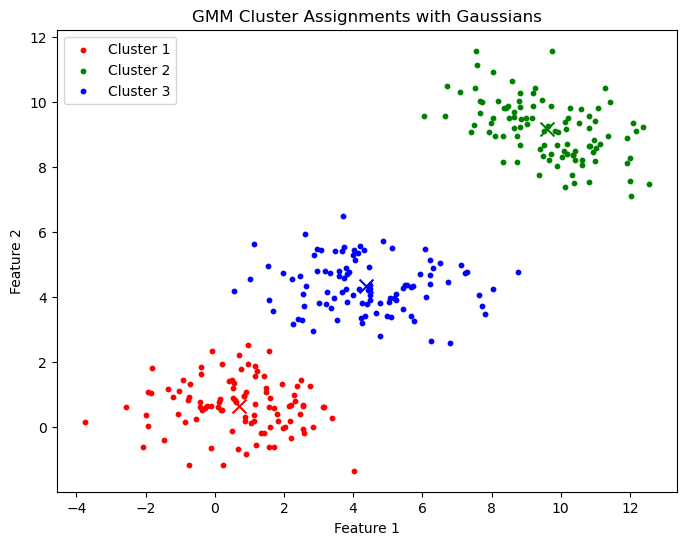

In [14]:

from matplotlib.patches import Ellipse

def plot_gaussian_ellipse(mean, cov, ax, n_std=2.0, facecolor='none', edgecolor='red', lw=2):
    
    eigenvals, eigenvecs = np.linalg.eigh(cov)
    order = eigenvals.argsort()[::-1]
    eigenvals, eigenvecs = eigenvals[order], eigenvecs[:, order]
    
    # Compute the angle between the x-axis and the largest eigenvector
    angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))
    
    # Width and height are "2 standard deviations" in each direction
    width, height = 2 * n_std * np.sqrt(eigenvals)
    
    # Create and add the ellipse patch
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                      facecolor=facecolor, edgecolor=edgecolor, lw=lw)
    ax.add_patch(ellipse)


fig, ax = plt.subplots(figsize=(8,6))

colors = ['red', 'green', 'blue']
for i in range(3):
    cluster_points = dataset[assignments == i]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], s=10, color=colors[i], label=f'Cluster {i+1}')
    ax.scatter(new_mean[i][0], new_mean[i][1], color=colors[i], s=100, marker='x')

ax.set_title("GMM Cluster Assignments with Gaussians")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.legend()
plt.show()



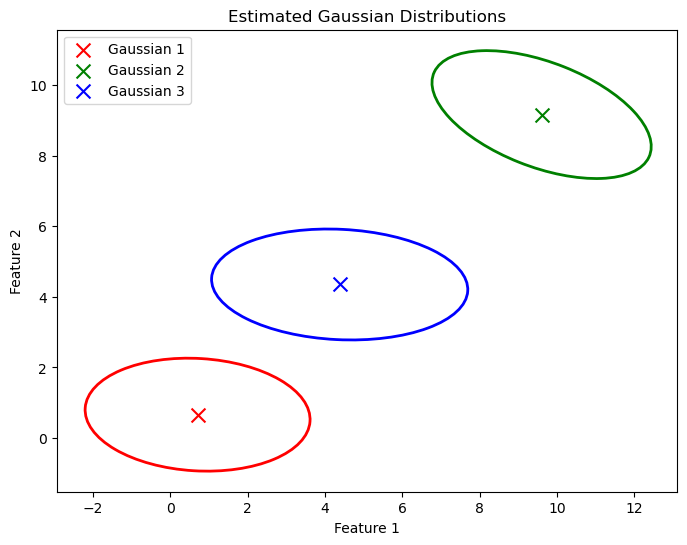

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
for i in range(3):
    plot_gaussian_ellipse(new_mean[i], new_cov[i], ax, n_std=2.0, edgecolor=colors[i])
    ax.scatter(new_mean[i][0], new_mean[i][1], color=colors[i], s=100, marker='x', label=f'Gaussian {i+1}')

ax.set_title("Estimated Gaussian Distributions")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.legend()
plt.show()